<a href="https://colab.research.google.com/github/Marim-medhat/Analyze-A-B-Test-Results/blob/main/pose_(yaw%2C_pitch%2C_roll)_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install mediapipe


In [ ]:

import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow
from sklearn.model_selection import cross_val_score,train_test_split


import numpy as np

from sklearn.metrics import mean_squared_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/ML1/AFLW2000-3D.zip

Archive:  /content/drive/MyDrive/ML1/AFLW2000-3D.zip
replace AFLW2000/Code/DrawSolidHead.m? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: AFLW2000/Code/DrawSolidHead.m  
  inflating: AFLW2000/Code/DrawTextureHead.m  
  inflating: AFLW2000/Code/main_show_without_BFM.m  
  inflating: AFLW2000/Code/main_show_with_BFM.m  
  inflating: AFLW2000/Code/Mex/compile.m  
  inflating: AFLW2000/Code/Mex/Tnorm_Vnorm.h  
  inflating: AFLW2000/Code/Mex/Tnorm_VnormC.cpp  
  inflating: AFLW2000/Code/Mex/Tnorm_VnormC.mexw64  
  inflating: AFLW2000/Code/ModelGeneration/ModelGenerate.m  
  inflating: AFLW2000/Code/ModelGeneration/model_info.mat  
  inflating: AFLW2000/Code/Model_Exp.mat  
  inflating: AFLW2000/Code/Model_Shape_Sim.mat  
  inflating: AFLW2000/Code/NormDirection.m  
  inflating: AFLW2000/Code/readme.txt  
  inflating: AFLW2000/Code/RotationMatrix.m  
  inflating: AFLW2000/Code/Tnorm_VnormC.mexw64  
  inflating: AFLW2000/image00002.jpg  
  inflating: AFLW2000/image00002.mat  
  inflati

In [ ]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

Preparing Data


In [ ]:
# list to The final path component for each mat files, without its suffix
mylist_jpg =[Path(f).stem for f in glob.glob("/content/AFLW2000/*.jpg")]

### User-defined-function

#when read mat file which contain information of each image , we get dictionary with keys
# 'Color_Para','Exp_Para','Illum_Para','Pose_Para','Shape_Para','__globals__'
#'__header__','__version__','pt2d','pt3d_68','roi'
## get yaw, pitch, roll for each image
def get_ypr_from_mat(mat_path):
    # Get yaw, pitch, roll from .mat annotation.
    # They are in radians
    mat = sio.loadmat(mat_path)
    # [pitch yaw roll tdx tdy tdz scale_factor]
    pre_pose_params = mat['Pose_Para'][0]
    # Get [pitch, yaw, roll]
    pose_params = pre_pose_params[:3]
    return pose_params




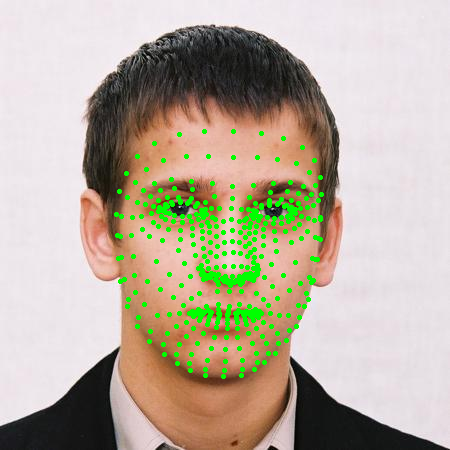

In [ ]:
# choosing random image
random_file = 'image00053'

faceModule = mediapipe.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
              cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
      cv2_imshow(image)

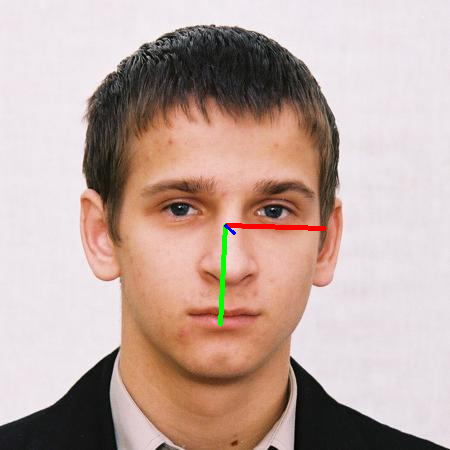

In [ ]:
image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat('/content/AFLW2000/'+random_file+'.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
cv2_imshow(draw_axis(image,pitch,yaw,roll))

In [ ]:



data_for_all_images=[]
name_for_all_images=[]
data_for_all_labels=[]

mp_face_mesh = mediapipe.solutions.face_mesh
face_mesh_images = mp_face_mesh.FaceMesh(static_image_mode=True)

for img in mylist_jpg:
  mat_path = os.path.join('/content/AFLW2000/',img + '.mat')
  image = cv2.imread(os.path.join('/content/AFLW2000/',img + '.jpg'))
  pose = get_ypr_from_mat(mat_path)
  pitch = pose[0] 
  yaw = pose[1] 
  roll = pose[2] 
  cont_labels = [yaw, pitch, roll]
  # we get landmark points (468 point) 
  results = face_mesh_images.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  landmarks_of_current_img=[]
  if results.multi_face_landmarks != None: 
    # looping over the faces in the image
    for face in results.multi_face_landmarks:
      for i,landmark in enumerate(face.landmark):
           
           x = landmark.x
           y = landmark.y
           # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
           shape = image.shape 
           relative_x = int(x * shape[1])
           relative_y = int(y * shape[0])
           landmarks_of_current_img.append(relative_x)
           landmarks_of_current_img.append(relative_y)

  name_for_all_images.append(img+'.jpg')
  data_for_all_images.append(np.array(landmarks_of_current_img,dtype=np.float32))
  data_for_all_labels.append(np.array(cont_labels,dtype=np.float32))



In [ ]:
df_label=pd.DataFrame(data_for_all_labels,columns=['yaw', 'pitch', 'roll'])

df = pd.DataFrame(data_for_all_images)
#train, test = train_test_split(df, test_size=0.2)

df.iloc[:,::2]=df.iloc[:,::2].sub(df.iloc[:,2],axis=0)
df.iloc[:,1::2]=df.iloc[:,1::2].sub(df.iloc[:,3],axis=0)


df[['yaw', 'pitch', 'roll']]=df_label

df['img']=name_for_all_images


# Reset index after drop
df=df.dropna()
df
df = df.sample(frac=1)
df

,0,1,2,3,4,5,6,7,8,9,...,930,931,932,933,934,935,yaw,pitch,roll,img
1192,2.0,29.0,0.0,0.0,1.0,8.0,-6.0,-29.0,0.0,-9.0,...,16.0,-47.0,62.0,-55.0,66.0,-58.0,0.146072,0.050486,-0.010034,image00697.jpg
1508,-13.0,31.0,0.0,0.0,-8.0,8.0,-5.0,-36.0,3.0,-10.0,...,15.0,-58.0,63.0,-63.0,68.0,-65.0,-0.272286,-0.237776,0.224699,image03967.jpg
222,-7.0,25.0,0.0,0.0,-5.0,7.0,-9.0,-28.0,1.0,-8.0,...,4.0,-48.0,42.0,-57.0,45.0,-60.0,-0.237585,-0.268419,0.023708,image02695.jpg
1287,14.0,20.0,0.0,0.0,8.0,4.0,-11.0,-25.0,-3.0,-7.0,...,7.0,-52.0,51.0,-77.0,54.0,-81.0,0.245164,-0.253653,-0.396502,image00747.jpg
1463,-14.0,23.0,0.0,0.0,-16.0,8.0,-13.0,-23.0,1.0,-7.0,...,-24.0,-40.0,-21.0,-46.0,-23.0,-48.0,-1.403351,-0.073267,0.123136,image01708.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,5.0,23.0,0.0,0.0,6.0,11.0,1.0,-15.0,0.0,-7.0,...,28.0,-24.0,70.0,-32.0,75.0,-35.0,0.361550,0.596134,0.020207,image04308.jpg
1982,-8.0,23.0,0.0,0.0,-4.0,7.0,-5.0,-29.0,2.0,-8.0,...,14.0,-47.0,59.0,-49.0,63.0,-52.0,-0.209457,-0.156068,0.191406,image03712.jpg
617,-10.0,21.0,0.0,0.0,-2.0,5.0,8.0,-34.0,4.0,-9.0,...,42.0,-46.0,98.0,-36.0,103.0,-38.0,0.118682,-0.198943,0.416217,image03549.jpg
1556,-7.0,26.0,0.0,0.0,-13.0,10.0,-18.0,-18.0,0.0,-7.0,...,-30.0,-34.0,-26.0,-45.0,-27.0,-47.0,-1.153661,0.135475,-0.340632,image02810.jpg


In [ ]:
df.isna().sum().max()

0


# yaw prediction with different models

In [ ]:
def df_with_high_correlations_col(label,df,num):
  #find the correlation between yaw and all the other coulmns
  corr_df=df[df.columns[:]].corr()[label]
  corr_df =abs(corr_df)
  #sorte by correlation value between yaw and all the other coulmns
  corr_df=corr_df.sort_values(ascending=False)
  # Convert to dataframe an get top 30 
  correlations = pd.DataFrame(corr_df).reset_index() 
  high_correlations=correlations.values[1:num]
  coul_high_corr=high_correlations[:,0]
  df_high=df[coul_high_corr]     
  return df_high,coul_high_corr
df_yaw,coul_high_corr_yaw=df_with_high_correlations_col("yaw",df,400)


In [ ]:
y = df.yaw
yaw_train, yaw_test, y_train, y_test = train_test_split(df_yaw, y,train_size=0.8, test_size=0.2)

## XGBRegressor model


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error


xmodel_yaw=XGBRegressor(learning_rate=0.001,n_estimators=200)
xmodel_yaw.fit(yaw_train,y_train)

preds_yaw= xmodel_yaw.predict(yaw_test)

mse = mean_squared_error(y_test, preds_yaw)
rmse = np.sqrt(mse)
print('RMSE: %f' % rmse)


[19:27:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 0.634563


## RandomForestRegressor model


In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_model_yaw = RandomForestRegressor(n_estimators=200, max_depth=20)
forest_model_yaw.fit(yaw_train, y_train)
predicted_random_forest = forest_model_yaw.predict(yaw_test)

mse = mean_squared_error(y_test, predicted_random_forest)
rmse = np.sqrt(mse)
print('RMSE: %f' % rmse)


RMSE: 0.175214


## SVR


In [ ]:
from sklearn.svm import SVR

svr_yaw = SVR()
svr_yaw.fit(yaw_train, y_train)
predictions = svr_yaw.predict(yaw_test)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 0.159277


In [ ]:
import plotly.graph_objects as go

RMSE_svr=[]
RMSE_RandomForestRegressor=[]
for i in range(10,100,20):
    svr_yaw=SVR(cache_size=i)
    svr_yaw.fit(yaw_train, y_train)
    predictions =svr_yaw.predict(yaw_test)
    mse = mean_squared_error(y_test, predictions)
    RMSE_svr.append( np.sqrt(mse))

    forest_model_yaw = RandomForestRegressor(n_estimators=i)
    forest_model_yaw.fit(yaw_train, y_train)
    predicted_random_forest = forest_model_yaw.predict(yaw_test)
    mse = mean_squared_error(y_test, predicted_random_forest)
    RMSE_RandomForestRegressor.append( np.sqrt(mse))

x =np.arange(10,200,20)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x,
    y=RMSE_svr,
    name = 'SVR', # Style name/legend entry with html tags
    connectgaps=True # override default to connect the gaps
))
fig.add_trace(go.Scatter(
    x=x,
    y=RMSE_RandomForestRegressor,
    name='RandomForestRegressor',
))


fig.update_layout(title='RMSE VS n_estimators ',
                   xaxis_title='n_estimators',
                   yaxis_title='RMSE')

fig.show()

# svr is the pest model for yaw



# roll prediction with different models

In [ ]:
df_roll,coul_high_corr_roll=df_with_high_correlations_col("roll",df,100)


In [ ]:
y = df.roll
#df_roll.drop(['yaw'], axis=1, inplace=True)
#df_roll.drop(['pitch'], axis=1, inplace=True)
roll_train, roll_test, y_train, y_test = train_test_split(df_roll, y,train_size=0.8, test_size=0.2)

## XGBRegressor model


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error


xmodel_roll=XGBRegressor(learning_rate=0.001,n_estimators=100)
xmodel_roll.fit(roll_train,y_train)

preds_roll= xmodel_roll.predict(roll_test)

mse = mean_squared_error(y_test, preds_roll)
rmse = np.sqrt(mse)
print('RMSE: %f' % rmse)


[19:29:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 1.041122


## RandomForestRegressor model


In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_model_roll = RandomForestRegressor(n_estimators=100,max_depth=200)
forest_model_roll.fit(roll_train, y_train)
predicted_random_forest = forest_model_roll.predict(roll_test)

mse = mean_squared_error(y_test, predicted_random_forest)
rmse = np.sqrt(mse)
print('RMSE: %f' % rmse)


RMSE: 0.834473


## SVR


In [ ]:
from sklearn.svm import SVR

svr_roll = SVR()
svr_roll.fit(roll_train, y_train)
predictions = svr_roll.predict(roll_test)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 0.822601


# svR is the pest model for roll







# pitch prediction with different models

In [ ]:

df_pitch,coul_high_corr_pitch=df_with_high_correlations_col("pitch",df,100)


In [ ]:
y = df.pitch
pitch_train, pitch_test, y_train, y_test = train_test_split(df_pitch, y,train_size=0.8, test_size=0.2)

## XGBRegressor model


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error


xmodel_pitch=XGBRegressor(learning_rate=0.001,n_estimators=600)
xmodel_pitch.fit(pitch_train,y_train)

preds_pitch= xmodel_pitch.predict(pitch_test)

mse = mean_squared_error(y_test, preds_pitch)
rmse = np.sqrt(mse)
print('RMSE: %f' % rmse)


[19:29:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 0.887424


In [ ]:
RMSE_XGBRegressor=[]
for i in range(10,300,20):
    
    xmodel_pitch=XGBRegressor(learning_rate=0.001,n_estimators=i)
    xmodel_pitch.fit(pitch_train,y_train)
    preds_pitch= xmodel_pitch.predict(pitch_test)
    mse = mean_squared_error(y_test, preds_pitch)
    rmse = np.sqrt(mse)
    RMSE_XGBRegressor.append( np.sqrt(mse))


x =np.arange(10,200,20)

fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    x=x,
    y=RMSE_XGBRegressor,
    name = 'XGBRegressor', # Style name/legend entry with html tags
    connectgaps=True # override default to connect the gaps
))



fig1.update_layout(title='RMSE VS n_estimators ',
                   xaxis_title='n_estimators',
                   yaxis_title='RMSE')

fig1.show()


[19:29:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:29:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:29:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:29:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:29:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:29:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:29:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:29:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

## RandomForestRegressor model


In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_model_pitch = RandomForestRegressor(n_estimators=10, max_depth=200)
forest_model_pitch.fit(pitch_train, y_train)
predicted_random_forest = forest_model_pitch.predict(pitch_test)

mse = mean_squared_error(y_test, predicted_random_forest)
rmse = np.sqrt(mse)
print('RMSE: %f' % rmse)


RMSE: 0.836442


## SVR


In [ ]:
from sklearn.svm import SVR

svr_pitch = SVR()
svr_pitch.fit(pitch_train, y_train)
predictions = svr_pitch.predict(pitch_test)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 0.829846


# test vedio
---



In [ ]:
import itertools
import pickle

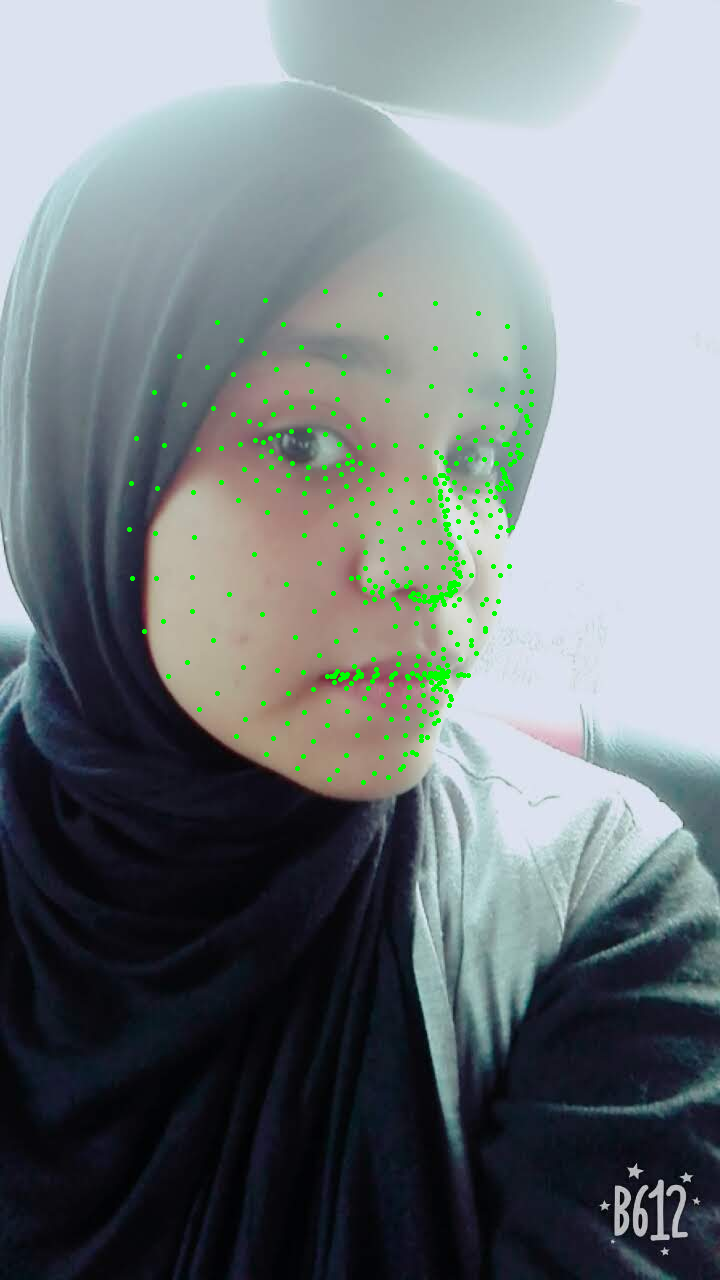

In [ ]:
landmarks_of_current_img=[]
face1 = mediapipe.solutions.face_mesh
# loading image and its correspinding mat file
with face1.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('/content/IMG-20180710-WA0015.jpg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
        # print lips landmark 
        # LIPS_INDEXES = list(set(itertools.chain(*face.FACEMESH_LIPS)))
        # for LIPS_INDEXE in LIPS_INDEXES[:2]:
        #   print(face.landmark[LIPS_INDEXE])

          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              landmarks_of_current_img.append(relative_x)
              landmarks_of_current_img.append(relative_y)
              # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
              cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
      cv2_imshow(image)

In [ ]:
landmarks_of_current_img
landmarks_to_pred = pd.DataFrame(landmarks_of_current_img).T
x=landmarks_to_pred[2][0]
y=landmarks_to_pred[3][0]
landmarks_to_pred.iloc[:,::2]=landmarks_to_pred.iloc[:,::2].sub(landmarks_to_pred.iloc[:,2],axis=0)
landmarks_to_pred.iloc[:,1::2]=landmarks_to_pred.iloc[:,1::2].sub(landmarks_to_pred.iloc[:,3],axis=0)
landmarks_to_pred


,0,1,2,3,4,5,6,7,8,9,...,926,927,928,929,930,931,932,933,934,935
0,-21,69,0,0,-22,21,-20,-65,4,-20,...,1,-112,-4,-108,-4,-105,65,-114,71,-123



# yaw prediction with SVR

In [ ]:
df_yaw=landmarks_to_pred[coul_high_corr_yaw]
df_prediction_yaw = svr_yaw.predict(df_yaw)

prediction_yaw=df_prediction_yaw[0]
prediction_yaw

-0.2989381899677742

# roll prediction with RandomForestRegressor



In [ ]:
df_roll=landmarks_to_pred[coul_high_corr_roll]
predicted_roll = forest_model_roll.predict(df_roll)
predicted_roll=predicted_roll[0]
predicted_roll

0.2587081034050789

# pitch prediction with SVR


In [ ]:
df_pitch=landmarks_to_pred[coul_high_corr_pitch]
predicted_pitch = svr_pitch.predict(df_pitch)
predicted_pitch=predicted_pitch[0]
predicted_pitch

-0.04363464379978005

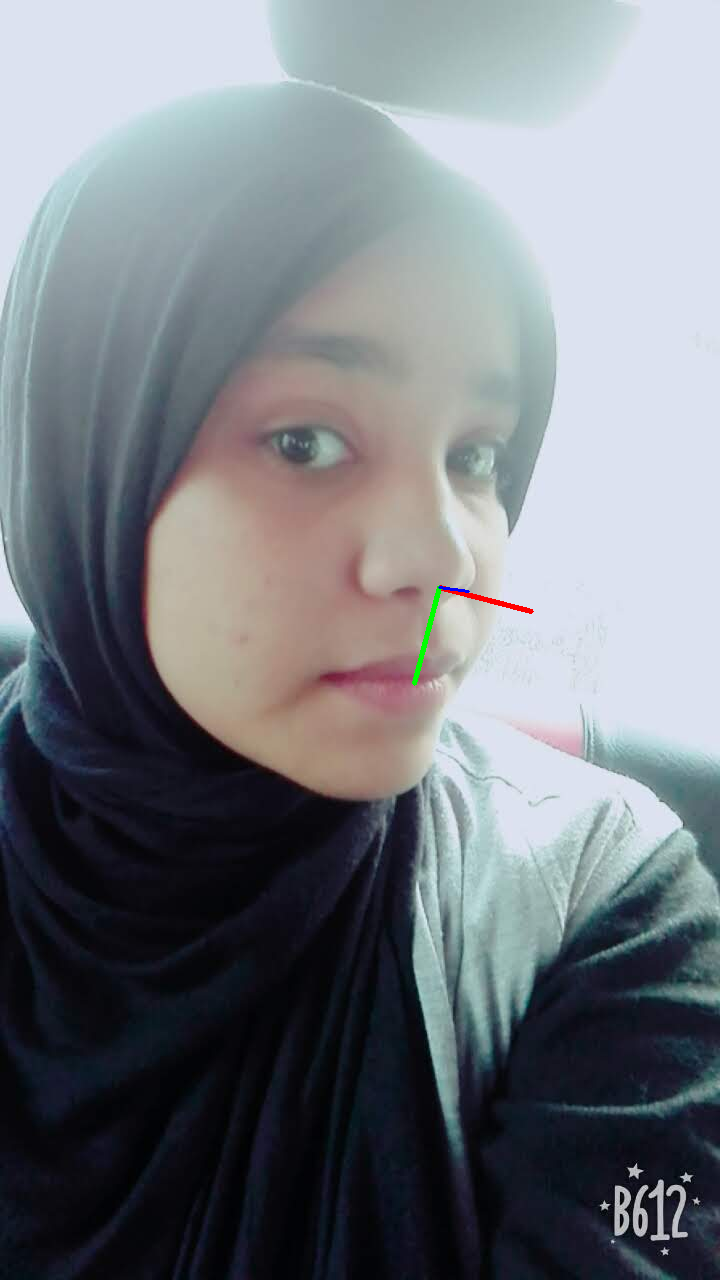

In [ ]:

image = cv2.imread('/content/IMG-20180710-WA0015.jpg')
shape = image.shape
cv2_imshow(draw_axis(image,predicted_pitch,prediction_yaw,predicted_roll,x, y))

In [ ]:
!wget https://dm0qx8t0i9gc9.cloudfront.net/watermarks/video/GtuAR0I/videoblocks-portrait-of-beautiful-ethnic-brunette-with-long-hair-smiling-at-camera-on-background-of-tropical-park_bqz41pcso4__fe0d8e247505fb2649f9d15e93b0ecd7__P360.mp4

--2022-06-17 19:29:59--  https://dm0qx8t0i9gc9.cloudfront.net/watermarks/video/GtuAR0I/videoblocks-portrait-of-beautiful-ethnic-brunette-with-long-hair-smiling-at-camera-on-background-of-tropical-park_bqz41pcso4__fe0d8e247505fb2649f9d15e93b0ecd7__P360.mp4
Resolving dm0qx8t0i9gc9.cloudfront.net (dm0qx8t0i9gc9.cloudfront.net)... 13.224.9.111, 13.224.9.109, 13.224.9.35, ...
Connecting to dm0qx8t0i9gc9.cloudfront.net (dm0qx8t0i9gc9.cloudfront.net)|13.224.9.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 509917 (498K) [video/mp4]
Saving to: ‘videoblocks-portrait-of-beautiful-ethnic-brunette-with-long-hair-smiling-at-camera-on-background-of-tropical-park_bqz41pcso4__fe0d8e247505fb2649f9d15e93b0ecd7__P360.mp4’

videoblocks-portrai 100%[===================>] 497.97K  --.-KB/s    in 0.03s   

2022-06-17 19:29:59 (14.8 MB/s) - ‘videoblocks-portrait-of-beautiful-ethnic-brunette-with-long-hair-smiling-at-camera-on-background-of-tropical-park_bqz41pcso4__fe0d8e247505fb

In [ ]:
v_path='/content/videoblocks-portrait-of-beautiful-ethnic-brunette-with-long-hair-smiling-at-camera-on-background-of-tropical-park_bqz41pcso4__fe0d8e247505fb2649f9d15e93b0ecd7__P360.mp4'
cap=cv2.VideoCapture(v_path)
fourcc=int(cap.get(cv2.CAP_PROP_FOURCC))

FPS=int(cap.get(cv2.CAP_PROP_FPS))
print(FPS)
draw = mediapipe.solutions.drawing_utils

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
size = (frame_width, frame_height)

faceModule = mediapipe.solutions.face_mesh
faces = faceModule.FaceMesh(static_image_mode=False)

#result = cv2.VideoWriter("/content/drive/MyDrive/1colab/ML1/2.avi", cv2.VideoWriter_fourcc('X','V','I','D'), FPS, size)
result = cv2.VideoWriter("/content/wrapper.mp4", cv2.VideoWriter_fourcc(*'MP4V'), FPS, size)

success, img = cap.read()
while (cap.isOpened()and success ): 
    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = faces.process(imgRGB)
    if results.multi_face_landmarks !=None:
      landmarks_of_current_img=[]

      landmarks=results.multi_face_landmarks[0]
      for landmark in landmarks.landmark:
          x = landmark.x
          y = landmark.y
      
          relative_x = int(img.shape[1] * x)
          relative_y = int(img.shape[0] * y)
          landmarks_of_current_img.append(relative_x)
          landmarks_of_current_img.append(relative_y)
      
      dx=landmarks_of_current_img[2]
      dy=landmarks_of_current_img[3]
      landmarks_to_pred_current = pd.DataFrame(landmarks_of_current_img).T
      landmarks_to_pred_current.iloc[:,::2]=landmarks_to_pred_current.iloc[:,::2].sub(landmarks_to_pred_current.iloc[:,2],axis=0)
      landmarks_to_pred_current.iloc[:,1::2]=landmarks_to_pred_current.iloc[:,1::2].sub(landmarks_to_pred_current.iloc[:,3],axis=0)


      df_yaw=landmarks_to_pred_current[coul_high_corr_yaw]
      df_prediction_yaw = svr_yaw.predict(df_yaw)
      yaw_current=df_prediction_yaw[0]

      df_pitch=landmarks_to_pred_current[coul_high_corr_pitch]
      predicted_pitch = svr_pitch.predict(df_pitch)
      pitch_current=predicted_pitch[0]

      df_roll=landmarks_to_pred_current[coul_high_corr_roll]
      predicted_roll = forest_model_roll.predict(df_roll)
      roll_current=predicted_roll[0]



      image4=draw_axis(img,pitch_current,yaw_current,roll_current,dx,dy)
      print(True)

        # draw.draw_landmarks(
        #   img,results.multi_face_landmarks[0])

    #cv2_imshow(img)
    result.write(image4)
    #cv2.waitKey(1)
    success, img = cap.read()
cap.release()
result.release()
cv2.destroyAllWindows()

25
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
Tr